# Capstone 2 Los Angeles Metro Bikes


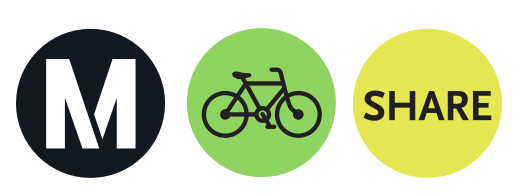

# Analyzing Usage and Trip Patterns
# Station Optimization
## Data Wrangling
By Oliver Bohler

## About the Project
The LA Metro Bike Share program launched in July 2016 with 65 stations and 1,000 bikes serving Downtown Los Angeles. A year later, Pasadena (30 stations) and the Port of Los Angeles (13 stations) joined the program. However, Pasadena exited the program after just one year, citing poor leadership, communication challenges, and the high costs of operation.

As a permanent resident of Los Angeles since 2017, I have personally witnessed the expansion of Metro Bike stations across the city and seen their popularity. The stations are clean, easily accessible, and frequently used by residents during their daily commutes.

Perhaps it was my European background and appreciation for public transportation, or maybe it was the open accessibility of the data—but I decided to take a deep dive into the LA Metro Bike Share system. I am a strong advocate for comprehensive and efficient public transportation networks.

The goal of this project is to leverage available data and gain insights into each station’s performance over the years. A data-driven, analytical approach can help optimize station locations and bike distribution, ensuring that government and city budgets are allocated efficiently. Additionally, new methods in the way data is analyzed and presented can address communication gaps and provide concrete answers to key questions raised by stakeholders and city officials.


## About the Data

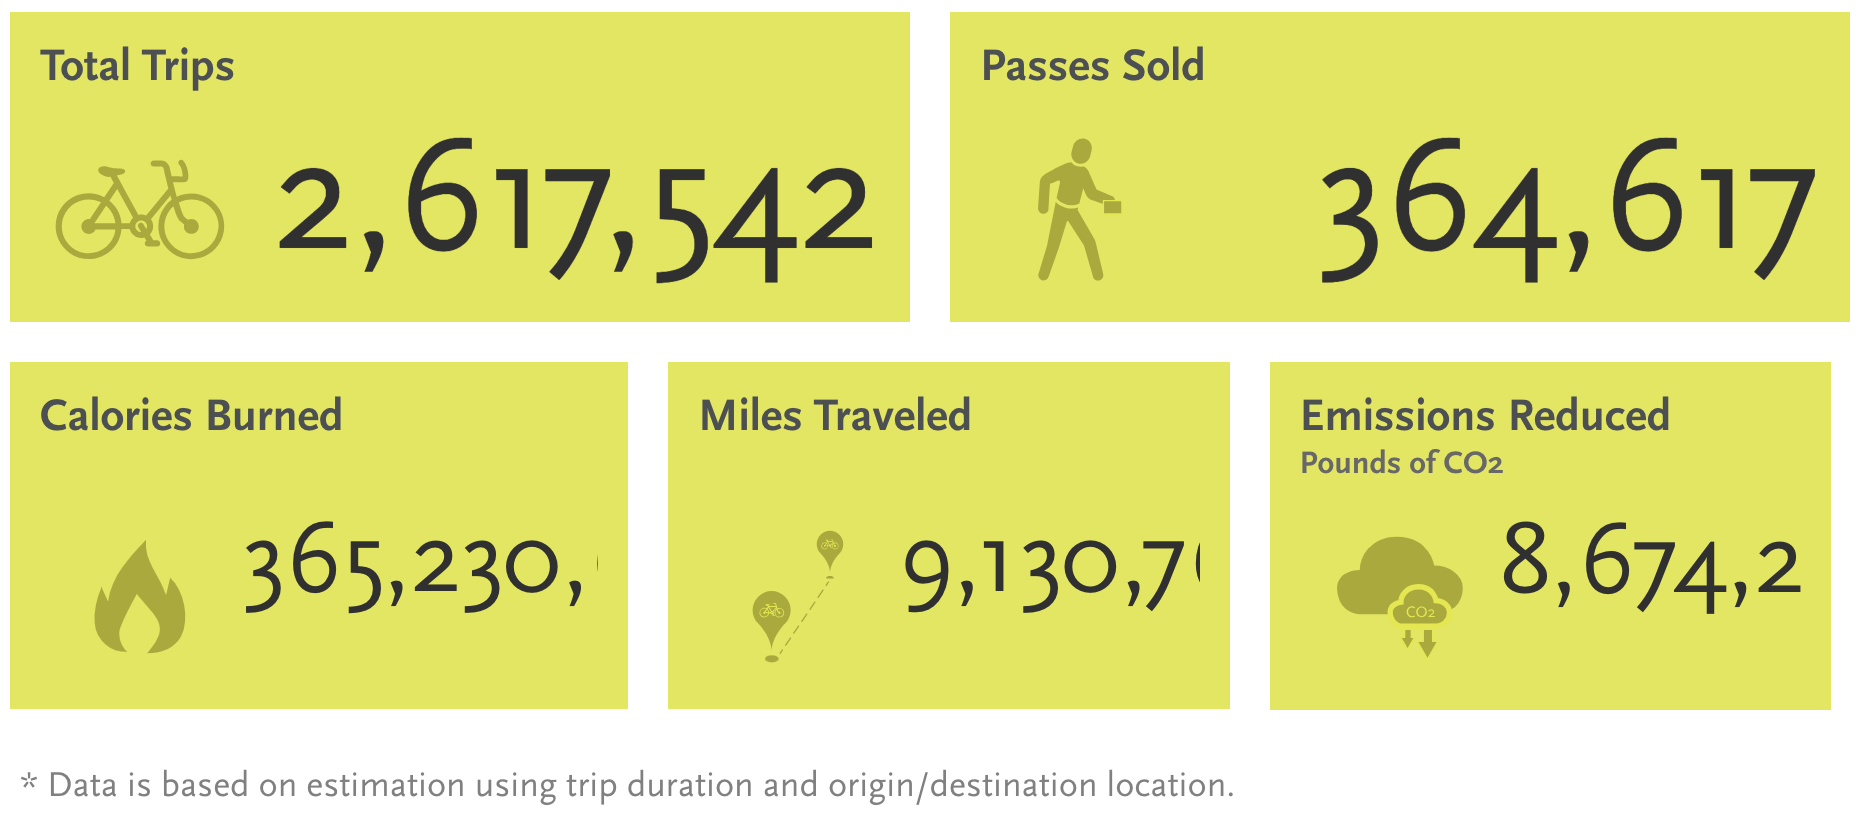

The project utilizes multiple real-world datasets, maps and api's to analyze and optimize the LA Metro Bike Share system. The primary dataset includes information on all 223 active Metro Bike stations, covering attributes such as trip duration, passholder type, trip distance, dock availability per station and station locations. These datasets are publicly accessible through the LA Metro website.

To enhance the optimization analysis, additional data sources were integrated, including Metro train and bus station locations, as well as points of interest, which were obtained from the Los Angeles County Database. Incorporating these features allows for a more comprehensive spatial analysis of station performance and potential relocation strategies.

The data is stored in quarterly files, which required preprocessing to consolidate them into a single structured dataset. Given that all files maintained a consistent schema, I opted to batch-load an entire folder of CSV files, streamlining the ingestion process and optimizing computational efficiency.

---

## The Cleaning Process

### Loading the Data
After succesfully batch-loading the trip files I am checking some basic information about data types and column names. I proceed loading the separate station information file and merge them into one dataframe.

In [439]:
import pandas as pd
import os
import requests
pd.options.display.max_columns = 400
pd.options.display.max_rows = 400

stations = pd.read_csv('/Users/oliverbohler/Desktop/Springboard/RideShare/metro-bike-share-stations-2024-04-01.csv', encoding='ISO-8859-1')
folder_path = '/Users/oliverbohler/Desktop/Springboard/RideShare/Metro_Rideshare_Data'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dataframes = []

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, encoding='ISO-8859-1',
                    low_memory = False
                    )  
    dataframes.append(df)

trips = pd.concat(dataframes, ignore_index=True)
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509531 entries, 0 to 1509530
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   trip_id              1509531 non-null  int64  
 1   duration             1509531 non-null  int64  
 2   start_time           1509531 non-null  object 
 3   end_time             1509531 non-null  object 
 4   start_station        1509531 non-null  int64  
 5   start_lat            1509045 non-null  float64
 6   start_lon            1509045 non-null  float64
 7   end_station          1509531 non-null  int64  
 8   end_lat              1478289 non-null  float64
 9   end_lon              1478288 non-null  float64
 10  bike_id              1509531 non-null  object 
 11  plan_duration        1509531 non-null  int64  
 12  trip_route_category  1509531 non-null  object 
 13  passholder_type      1504646 non-null  object 
 14  bike_type            1509531 non-null  object 
 15

In [441]:
trips.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,start station name,end station name
0,197704064,21,7/1/2022 0:00,7/1/2022 0:21,4606,34.168629,-118.377068,4601,34.161709,-118.372818,19544,1,One Way,Walk-up,electric,NaN,NaN
1,197703662,2,7/1/2022 0:02,7/1/2022 0:04,4406,34.101891,-118.300613,4442,34.098000,-118.300468,24302,30,One Way,Monthly Pass,electric,NaN,NaN
2,197704062,3,7/1/2022 0:19,7/1/2022 0:22,3082,34.046520,-118.237411,3082,34.046520,-118.237411,19941,1,Round Trip,Walk-up,electric,NaN,NaN
3,197704162,2,7/1/2022 0:23,7/1/2022 0:25,3082,34.046520,-118.237411,3082,34.046520,-118.237411,17445,1,Round Trip,Walk-up,electric,NaN,NaN
4,197708062,39,7/1/2022 0:26,7/1/2022 1:05,3082,34.046520,-118.237411,3063,34.048038,-118.253738,19941,1,One Way,Walk-up,electric,NaN,NaN


In [443]:
trips.shape

(1509531, 17)

---
### Station ID

To enable the merging of station information from the **stations table** with trip data in the **trips table**, it was necessary to preprocess the `station_id` column by converting it into an **integer type**. This ensures accurate joins without data loss.

Additionally, redundant columns with no valuable information were removed. Specifically, columns labeled as `Unnamed` were dropped, as they contained only **NaN values**, resulting from empty or misaligned data during import.

---

In [446]:
stations.head()

,Station_ID,Station_Name,Day of Go_live_date,Region,Status,Latitude,Longitude,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,3000.0,Virtual Station,7/7/2016,NaN,Active,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3005.0,7th & Flower,7/7/2016,DTLA,Active,34.048500,-118.258537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active,34.045540,-118.256668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3007.0,5th & Grand,7/7/2016,DTLA,Active,34.050480,-118.254593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,34.046612,-118.262733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [448]:
stations['Station_ID'] = pd.to_numeric(stations['Station_ID'], errors='coerce')
stations['Station_ID'] = stations['Station_ID'].astype('Int64')  
print(stations.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Station_ID           413 non-null    Int64  
 1   Station_Name         413 non-null    object 
 2   Day of Go_live_date  413 non-null    object 
 3   Region               412 non-null    object 
 4   Status               413 non-null    object 
 5   Latitude             413 non-null    float64
 6   Longitude            413 non-null    float64
 7   Unnamed: 7           0 non-null      float64
 8   Unnamed: 8           0 non-null      float64
 9   Unnamed: 9           0 non-null      float64
 10  Unnamed: 10          0 non-null      float64
 11  Unnamed: 11          0 non-null      float64
 12  Unnamed: 12          0 non-null      float64
 13  Unnamed: 13          0 non-null      float64
 14  Unnamed: 14          0 non-null      float64
 15  Unnamed: 15          0 non-null      flo

In [450]:
stations.columns = stations.columns.str.strip()
stations = stations.drop(columns=[col for col in stations.columns if 'Unnamed' in col])

---
### Merging

The merging process creates a DataFrame called `rideshare` that combines trip data with station details (e.g., name, region, status) for all stations. 

This is achieved by joining the `stations` table with the `trips` table using the common column `Station_ID`. This allows us to associate each trip with its respective station's name, region, and operational status. 

The resulting `rideshare` DataFrame will be used for the remainder of the data cleaning and analysis process.

---

In [453]:
# Merge for starting stations
rideshare_start = trips.merge(
    stations[['Station_ID', 'Station_Name', 'Region','Status']],  
    left_on='start_station',  
    right_on='Station_ID',  
    how='left' 
).rename(columns={
    'Station_Name': 'start_station_name',
    'Region': 'start_station_region',
    'Status': 'start_status'
}).drop(columns=['Station_ID']) 
# Merge for ending stations
rideshare = rideshare_start.merge(
    stations[['Station_ID', 'Station_Name', 'Region','Status']],  
    left_on='end_station',  
    right_on='Station_ID',  
    how='left'  
).rename(columns={
    'Station_Name': 'end_station_name',
    'Region': 'end_station_region',
    'Status': 'end_status'
}).drop(columns=['Station_ID'])  

rideshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509531 entries, 0 to 1509530
Data columns (total 23 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   trip_id               1509531 non-null  int64  
 1   duration              1509531 non-null  int64  
 2   start_time            1509531 non-null  object 
 3   end_time              1509531 non-null  object 
 4   start_station         1509531 non-null  int64  
 5   start_lat             1509045 non-null  float64
 6   start_lon             1509045 non-null  float64
 7   end_station           1509531 non-null  int64  
 8   end_lat               1478289 non-null  float64
 9   end_lon               1478288 non-null  float64
 10  bike_id               1509531 non-null  object 
 11  plan_duration         1509531 non-null  int64  
 12  trip_route_category   1509531 non-null  object 
 13  passholder_type       1504646 non-null  object 
 14  bike_type             1509531 non-

In [455]:
rideshare.drop(columns=['start station name', 'end station name', 'plan_duration'], inplace = True)
rideshare.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,trip_route_category,passholder_type,bike_type,start_station_name,start_station_region,start_status,end_station_name,end_station_region,end_status
0,197704064,21,7/1/2022 0:00,7/1/2022 0:21,4606,34.168629,-118.377068,4601,34.161709,-118.372818,19544,One Way,Walk-up,electric,North Hollywood Station,North Hollywood,Active,Lankershim & Hesby,North Hollywood,Active
1,197703662,2,7/1/2022 0:02,7/1/2022 0:04,4406,34.101891,-118.300613,4442,34.098000,-118.300468,24302,One Way,Monthly Pass,electric,Normandie & Hollywood,DTLA,Active,Normandie & Sunset,DTLA,Active
2,197704062,3,7/1/2022 0:19,7/1/2022 0:22,3082,34.046520,-118.237411,3082,34.046520,-118.237411,19941,Round Trip,Walk-up,electric,Traction & Rose,DTLA,Active,Traction & Rose,DTLA,Active
3,197704162,2,7/1/2022 0:23,7/1/2022 0:25,3082,34.046520,-118.237411,3082,34.046520,-118.237411,17445,Round Trip,Walk-up,electric,Traction & Rose,DTLA,Active,Traction & Rose,DTLA,Active
4,197708062,39,7/1/2022 0:26,7/1/2022 1:05,3082,34.046520,-118.237411,3063,34.048038,-118.253738,19941,One Way,Walk-up,electric,Traction & Rose,DTLA,Active,Pershing Square,DTLA,Active


---
### Re-arranging Column Orders

For better workflow, the column order in the `rideshare` DataFrame has been re-arranged. This new order groups related information together, making the DataFrame easier to navigate and understand.

- **Trip Details:** Includes all columns related to trip-specific information 
- **Starting Station Details:** Groups all columns related to the starting station of the trip
- **Ending Station Details:** Groups all columns related to the ending station of the trip

By re-organizing the columns in this way, the DataFrame becomes more intuitive and reduces the cognitive load during data exploration.

---

In [458]:
column_order = [
    # Trip Details
    'trip_id', 'start_time', 'end_time', 'duration', 
    'trip_route_category', 'passholder_type', 'bike_id', 'bike_type',
    # Starting Station Details
    'start_station', 'start_station_name', 'start_station_region', 
    'start_status','start_lat', 'start_lon',
    # Ending Station Details
    'end_station', 'end_station_name', 'end_station_region',
    'end_status','end_lat', 'end_lon', 
]
rideshare = rideshare[column_order]
rideshare.head()

,trip_id,start_time,end_time,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_status,start_lat,start_lon,end_station,end_station_name,end_station_region,end_status,end_lat,end_lon
0,197704064,7/1/2022 0:00,7/1/2022 0:21,21,One Way,Walk-up,19544,electric,4606,North Hollywood Station,North Hollywood,Active,34.168629,-118.377068,4601,Lankershim & Hesby,North Hollywood,Active,34.161709,-118.372818
1,197703662,7/1/2022 0:02,7/1/2022 0:04,2,One Way,Monthly Pass,24302,electric,4406,Normandie & Hollywood,DTLA,Active,34.101891,-118.300613,4442,Normandie & Sunset,DTLA,Active,34.098000,-118.300468
2,197704062,7/1/2022 0:19,7/1/2022 0:22,3,Round Trip,Walk-up,19941,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411
3,197704162,7/1/2022 0:23,7/1/2022 0:25,2,Round Trip,Walk-up,17445,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411
4,197708062,7/1/2022 0:26,7/1/2022 1:05,39,One Way,Walk-up,19941,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3063,Pershing Square,DTLA,Active,34.048038,-118.253738


---
### Passholder types
To ensure good data, Testing passes were dropped due to having barely any affect for the purpose of this project.

---

In [461]:
passholders = rideshare['passholder_type'].value_counts()
passholders

passholder_type
Monthly Pass    872624
Walk-up         343634
One Day Pass    144571
Annual Pass     143811
Testing              6
Name: count, dtype: int64

In [463]:
rideshare = rideshare[~rideshare['passholder_type'].isin(['Testing'])]
rideshare['passholder_type'].value_counts()

passholder_type
Monthly Pass    872624
Walk-up         343634
One Day Pass    144571
Annual Pass     143811
Name: count, dtype: int64

---
## Handling Virtual Station (ID: 3000)

#### What is a Virtual Station?
A "Virtual Station" (Station ID: 3000) is used for special scenarios such as:
- **Staff Operations:** When bikes are checked in or out remotely by staff
- **Special Events:** Temporary setups for events or emergencies
- **Incomplete Data:** Trips starting or ending at the virtual station often lack sufficient data for meaningful analysis

#### Objective
Since trips involving the virtual station are not representative of regular rides, they will be excluded from the dataset.

- **Identify Virtual Station Trips:**
   - Filter trips where either the `start_station` or `end_station` equals `3000`
   - Count the number of such trips
---
- **Calculate the Impact:**
   - Compute the percentage of trips involving the virtual station relative to the total number of trips
---

In [466]:
virtual_station = rideshare[(rideshare['start_station'] == 3000) | (rideshare['end_station']==3000)]
vs_count = virtual_station.shape[0]
total_trips = rideshare.shape[0]
vs_percentage = (vs_count/total_trips) * 100
print(f"Total number of trips: {total_trips}")
print(f"Total number of trips involving the virtual station: {vs_count}")
print(f"Percentage of trips involving the virtual station: {vs_percentage:.2f}%")

Total number of trips: 1509525
Total number of trips involving the virtual station: 30965
Percentage of trips involving the virtual station: 2.05%


---
**Remove Virtual Station Trips:**
   - Filter out trips involving the virtual station from the dataset

---

In [469]:
rideshare = rideshare[(rideshare['start_station'] != 3000) & (rideshare['end_station'] != 3000)]

---
### Dropping Duplicated Entries
It is very common in datasets to have duplicate entries. The code below is scanning the data for duplicate entries and removes them. Duplicate entries can be due to system or human error.

---

In [472]:
duplicates = rideshare[rideshare.duplicated()]
if duplicates.empty:
    print("No duplicates found.")
else:
    print("Duplicates found.")
    duplicate_count = duplicates.shape[0]
    print(f"Number of duplicate rows: {duplicate_count}")
    rideshare = rideshare.drop_duplicates()
    print(f"All {duplicate_count} duplicates have been dropped")

Duplicates found.
Number of duplicate rows: 17495
All 17495 duplicates have been dropped


---
### A First Look at Missing Values

Every dataset has missing values, and addressing them is a critical step in ensuring data quality. Identifying and understanding why values are missing helps to decide whether to clean, impute, or drop the affected data without losing valuable insights.


#### Next Steps:
- Focus will be placed on exploring the affected columns, particularly station-related ones
- Strategies such as imputation or filtering will be applied where appropriate to preserve data integrity and minimize information loss.

---

In [475]:
missing_values = pd.concat([rideshare.isnull().sum(), 100 * rideshare.isnull().mean()], axis = 1)
missing_values.columns = ['count','%']
missing_values.sort_values(by = 'count', ascending = False)

,count,%
end_status,6721,0.460007
end_station_region,6721,0.460007
end_station_name,6721,0.460007
start_station_region,6527,0.446729
start_station_name,6527,0.446729
start_status,6527,0.446729
passholder_type,4783,0.327364
end_lon,354,0.024229
end_lat,352,0.024092
start_lat,272,0.018617


---
#### Initial Observations:
- Missing values were identified across approximately half of the columns in the dataset
- The total amount of missing data accounts for **1.17%** of the dataset
- While the overall percentage of missing data is low, some columns with missing values, such as those related to stations, warrant closer inspection
---

In [478]:
missing_percentage = (rideshare.isna().any(axis=1).sum() / len(rideshare)) * 100
print(f"Percentage of rows with missing values: {missing_percentage:.2f}%")

Percentage of rows with missing values: 1.17%


---
### The Missing Station Information

As mentioned at the beginning of this project, the data includes all trips and stations that have been active since the launch of the LA Metro Bike Share program. 

The first approach was to identify if stations missing starting/ending names and regions share the same `station_id`. Once this was confirmed, further examination was performed on the `region` column.

#### Key Findings:
- Some stations and their corresponding regions were identified as missing
- Upon analysis, it was revealed that these stations belonged to areas, such as **Pasadena**, where the bike share program has since been discontinued
- Despite being inactive, these stations and regions remain in the dataset, leading to discrepancies in the trip and station-level data

The presence of closed stations introduces noise in the analysis and could distort insights regarding trip demand and station usage patterns. Therefore, removing these stations  is necessary for accurate analysis and reporting.

---


In [483]:
missing_start_stations = rideshare[rideshare['start_station_name'].isnull()]['start_station'].unique()
missing_end_stations = rideshare[rideshare['end_station_name'].isnull()]['end_station'].unique()
print("Missing Start Station IDs:", missing_start_stations)
print("Missing End Station IDs:", missing_end_stations)

Missing Start Station IDs: [4669 4670 4671 4672 4675 4678 4680 4682 4684 4686 4687 4689]
Missing End Station IDs: [4669 4670 4671 4672 4675 4678 4680 4682 4684 4686 4687 4689]


In [485]:
stations['Region'].value_counts()

Region
DTLA               193
Westside           138
North Hollywood     35
Pasadena            31
Port of LA          13
Free Bikes           2
Name: count, dtype: int64

---
### Status: Active or Inactive

The rideshare dataframe includes information about each station's status, indicating whether it is **active** (operating) or **inactive** (closed). 

#### Cleaning Process:
- The `status` column was used to filter out trips involving **inactive** stations
- Any trip where either the starting or ending station is marked as **inactive** was excluded

---

In [489]:
station_status_comparison = (
    rideshare.groupby(['start_station', 'start_status'])
    .size()
    .reset_index(name='Count')
)
comparison = station_status_comparison.pivot_table(
    index='start_station',
    columns='start_status',
    values='Count',
    fill_value=0
).reset_index()
print("Side-by-Side Comparison:")
print(comparison.head())

Side-by-Side Comparison:
start_status  start_station   Active  Inactive
0                      3005  38696.0       0.0
1                      3006  24909.0       0.0
2                      3007  10290.0       0.0
3                      3008  12690.0       0.0
4                      3010   2179.0       0.0


In [491]:
before_shape = rideshare.shape
rideshare = rideshare[rideshare['start_status'] == 'Active']
rideshare = rideshare[rideshare['end_status'] == 'Active']
after_shape = rideshare.shape

print(f"Shape before: {before_shape}")
print(f"Shape after: {after_shape}")

Shape before: (1461065, 20)
Shape after: (1423775, 20)


---
### Missing Values for Pass Holders

#### Analysis of Missing Data:
- The `passholder_type` column contains a small amount of missing data, approximately **3%** of the total values in that column
- Instead of dropping these missing values, the percentage is deemed small enough to compute the **most frequent passholder type** (mode) and fill the missing entries with this value

#### Final Step for Missing Values:
- Columns `end_lon`, `end_lat`, `start_lon`, and `start_lat` are critical for geospatial analysis and cannot have missing values
- Any rows with missing data in these columns are dropped to ensure the integrity of the dataset
---

In [494]:
missing_values = pd.concat([rideshare.isnull().sum(), 100 * rideshare.isnull().mean()], axis = 1)
missing_values.columns = ['count','%']
missing_values.sort_values(by = 'count', ascending = False)

,count,%
passholder_type,4551,0.319643
end_lon,113,0.007937
end_lat,111,0.007796
start_lon,111,0.007796
start_lat,111,0.007796
start_status,0,0.000000
end_status,0,0.000000
end_station_region,0,0.000000
end_station_name,0,0.000000
end_station,0,0.000000


In [496]:
# Fill missing passhohler types with the mode
rideshare['passholder_type'] = rideshare['passholder_type'].fillna(rideshare['passholder_type'].mode()[0])

In [498]:
rideshare = rideshare.dropna()
rideshare.shape

(1423662, 20)

### The Cleaned Dataframe
In the statstic below I confirm that all missing values have been either computationally filled or dropped. 

In [501]:
missing_values = pd.concat([rideshare.isnull().sum(), 100 * rideshare.isnull().mean()], axis = 1)
missing_values.columns = ['count','%']
missing_values.sort_values(by = 'count', ascending = False)

,count,%
trip_id,0,0.0
start_time,0,0.0
end_lat,0,0.0
end_status,0,0.0
end_station_region,0,0.0
end_station_name,0,0.0
end_station,0,0.0
start_lon,0,0.0
start_lat,0,0.0
start_status,0,0.0


---
### Converting Date and Time Columns

#### 1. Why Convert `start_time` and `end_time`?
The `start_time` and `end_time` columns originally contain both **date** and **time** information in a single string format. Converting these columns to `datetime` format is important for several reasons:

- **Easier Operations:**
  - Allows for easy extraction of specific components (e.g., date or time)
  - Enables datetime operations such as calculating trip durations or sorting trips chronologically
  - Facilitates time-based analysis, like finding peak hours or daily trends

---

In [505]:
rideshare['start_time_new'] = pd.to_datetime(rideshare['start_time'], errors='coerce').dt.time
rideshare['end_time_new'] = pd.to_datetime(rideshare['end_time'], errors='coerce').dt.time
rideshare['start_date'] = pd.to_datetime(rideshare['start_time'], errors='coerce').dt.date
rideshare['end_date'] = pd.to_datetime(rideshare['end_time'], errors='coerce').dt.date


rideshare.head()

,trip_id,start_time,end_time,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_status,start_lat,start_lon,end_station,end_station_name,end_station_region,end_status,end_lat,end_lon,start_time_new,end_time_new,start_date,end_date
0,197704064,7/1/2022 0:00,7/1/2022 0:21,21,One Way,Walk-up,19544,electric,4606,North Hollywood Station,North Hollywood,Active,34.168629,-118.377068,4601,Lankershim & Hesby,North Hollywood,Active,34.161709,-118.372818,00:00:00,00:21:00,2022-07-01,2022-07-01
1,197703662,7/1/2022 0:02,7/1/2022 0:04,2,One Way,Monthly Pass,24302,electric,4406,Normandie & Hollywood,DTLA,Active,34.101891,-118.300613,4442,Normandie & Sunset,DTLA,Active,34.098000,-118.300468,00:02:00,00:04:00,2022-07-01,2022-07-01
2,197704062,7/1/2022 0:19,7/1/2022 0:22,3,Round Trip,Walk-up,19941,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,00:19:00,00:22:00,2022-07-01,2022-07-01
3,197704162,7/1/2022 0:23,7/1/2022 0:25,2,Round Trip,Walk-up,17445,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,00:23:00,00:25:00,2022-07-01,2022-07-01
4,197708062,7/1/2022 0:26,7/1/2022 1:05,39,One Way,Walk-up,19941,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3063,Pershing Square,DTLA,Active,34.048038,-118.253738,00:26:00,01:05:00,2022-07-01,2022-07-01


---
#### 2. Why Extract `year`, `month`, `day`, and `day_name`?
Extracting these components provides additional temporal granularity for analysis:

- **`year`:**
  - Useful for tracking annual changes in ridership

---

- **`month`:**
  - Useful for analyzing seasonal variations, such as summer vs. winter trends

---

- **`day`:**
  - Provides a detailed granularity for trip counts on specific dates

---

- **`day_name`:**
  - Useful for differentiating between weekdays and weekends

---

In [508]:
rideshare['start_date'] = pd.to_datetime(rideshare['start_date'], errors='coerce')
rideshare['year'] = rideshare['start_date'].dt.year
rideshare['month'] = rideshare['start_date'].dt.month
rideshare['day'] = rideshare['start_date'].dt.day
rideshare['day_name'] = rideshare['start_date'].dt.day_name()

In [510]:
rideshare.head()

,trip_id,start_time,end_time,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_status,start_lat,start_lon,end_station,end_station_name,end_station_region,end_status,end_lat,end_lon,start_time_new,end_time_new,start_date,end_date,year,month,day,day_name
0,197704064,7/1/2022 0:00,7/1/2022 0:21,21,One Way,Walk-up,19544,electric,4606,North Hollywood Station,North Hollywood,Active,34.168629,-118.377068,4601,Lankershim & Hesby,North Hollywood,Active,34.161709,-118.372818,00:00:00,00:21:00,2022-07-01,2022-07-01,2022,7,1,Friday
1,197703662,7/1/2022 0:02,7/1/2022 0:04,2,One Way,Monthly Pass,24302,electric,4406,Normandie & Hollywood,DTLA,Active,34.101891,-118.300613,4442,Normandie & Sunset,DTLA,Active,34.098000,-118.300468,00:02:00,00:04:00,2022-07-01,2022-07-01,2022,7,1,Friday
2,197704062,7/1/2022 0:19,7/1/2022 0:22,3,Round Trip,Walk-up,19941,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,00:19:00,00:22:00,2022-07-01,2022-07-01,2022,7,1,Friday
3,197704162,7/1/2022 0:23,7/1/2022 0:25,2,Round Trip,Walk-up,17445,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,00:23:00,00:25:00,2022-07-01,2022-07-01,2022,7,1,Friday
4,197708062,7/1/2022 0:26,7/1/2022 1:05,39,One Way,Walk-up,19941,electric,3082,Traction & Rose,DTLA,Active,34.046520,-118.237411,3063,Pershing Square,DTLA,Active,34.048038,-118.253738,00:26:00,01:05:00,2022-07-01,2022-07-01,2022,7,1,Friday


In [512]:
column_order = [
    # Trip Details
    'trip_id','year', 'month', 'day', 'day_name', 'start_date', 'end_date', 'start_time_new', 'end_time_new', 'duration', 
    'trip_route_category', 'passholder_type', 'bike_id', 'bike_type',
    # Starting Station Details
    'start_station', 'start_station_name', 'start_station_region',
    'start_lat', 'start_lon', 
    # Ending Station Details
    'end_station', 'end_station_name', 'end_station_region',
    'end_lat', 'end_lon', 
]
rideshare = rideshare[column_order]
rideshare.head()

,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon
0,197704064,2022,7,1,Friday,2022-07-01,2022-07-01,00:00:00,00:21:00,21,One Way,Walk-up,19544,electric,4606,North Hollywood Station,North Hollywood,34.168629,-118.377068,4601,Lankershim & Hesby,North Hollywood,34.161709,-118.372818
1,197703662,2022,7,1,Friday,2022-07-01,2022-07-01,00:02:00,00:04:00,2,One Way,Monthly Pass,24302,electric,4406,Normandie & Hollywood,DTLA,34.101891,-118.300613,4442,Normandie & Sunset,DTLA,34.098000,-118.300468
2,197704062,2022,7,1,Friday,2022-07-01,2022-07-01,00:19:00,00:22:00,3,Round Trip,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411
3,197704162,2022,7,1,Friday,2022-07-01,2022-07-01,00:23:00,00:25:00,2,Round Trip,Walk-up,17445,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411
4,197708062,2022,7,1,Friday,2022-07-01,2022-07-01,00:26:00,01:05:00,39,One Way,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3063,Pershing Square,DTLA,34.048038,-118.253738


---
### Filtering Suspicious Rides

#### Step 1: Identifying Suspicious Rides
- **Objective:** Detect and quantify trips with unusual durations that may indicate data errors or outliers.
- **Filters Applied:**
  - Trips with a duration of `1` minute
  - Trips with a duration of `1440` minutes (24 hours)
- **Reasoning:**
  - A `1`-minute duration is likely unrealistic for most rides, indicating a potential error or incomplete data
  - A `1440`-minute duration might represent a data entry error or an anomalous case such as a bike being rented but not used for a full day

---

In [516]:
suspicious_rides = rideshare[(rideshare['duration'] == 1) | (rideshare['duration'] == 1440)]

print(f"Number of rides with 1 minute duration: {suspicious_rides[suspicious_rides['duration'] == 1].shape[0]}")
print(f"Number of rides with 1440 minutes (24h) duration: {suspicious_rides[suspicious_rides['duration'] == 1440].shape[0]}")
total_rides = rideshare.shape[0]
suspicious_count = suspicious_rides.shape[0]
print(f"Suspicious rides percentage: {suspicious_count / total_rides * 100:.2f}%")

Number of rides with 1 minute duration: 36032
Number of rides with 1440 minutes (24h) duration: 1526
Suspicious rides percentage: 2.64%


---
#### Step 2: Analyzing Suspicious Rides
- **Count Suspicious Rides:**
  - The number of `1-minute` and `1440-minute` rides is calculated separately to assess the extent of the issue
- **Breakdown by Categories:**
  - The `passholder_type` and `trip_route_category` are analyzed for these suspicious durations to identify patterns
---

In [519]:
rides_1_minute = rideshare[rideshare['duration'] == 1]
print(rides_1_minute['passholder_type'].value_counts())
print(rides_1_minute['trip_route_category'].value_counts())
rides_1440_minutes = rideshare[rideshare['duration'] == 1440]
print(rides_1440_minutes['passholder_type'].value_counts())
print(rides_1440_minutes['trip_route_category'].value_counts())

passholder_type
Monthly Pass    19451
Walk-up          7208
Annual Pass      5350
One Day Pass     4023
Name: count, dtype: int64
trip_route_category
Round Trip    33332
One Way        2700
Name: count, dtype: int64
passholder_type
Walk-up         883
One Day Pass    390
Monthly Pass    217
Annual Pass      36
Name: count, dtype: int64
trip_route_category
One Way       981
Round Trip    545
Name: count, dtype: int64


In [521]:
one_minute_ride = rideshare[
    (rideshare['duration'] == 1) & 
    (rideshare['trip_route_category'] == 'One Way')
]
one_minute_ride.head()

,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon
157,197748162,2022,7,1,Friday,2022-07-01,2022-07-01,10:35:00,10:36:00,1,One Way,Annual Pass,12126,standard,4516,7th & Hill,DTLA,34.045849,-118.254402,3031,7th & Spring,DTLA,34.044701,-118.252441
967,197862863,2022,7,2,Saturday,2022-07-02,2022-07-02,09:02:00,09:03:00,1,One Way,Monthly Pass,13564,standard,3008,Figueroa & 9th,DTLA,34.046612,-118.262733,4512,Figueroa & 11th,DTLA,34.043812,-118.264969
3158,198160900,2022,7,4,Monday,2022-07-04,2022-07-04,17:03:00,17:04:00,1,One Way,One Day Pass,5739,standard,3006,Olive & 8th,DTLA,34.045540,-118.256668,3064,Grand & 8th,DTLA,34.046131,-118.257591
3682,198220362,2022,7,5,Tuesday,2022-07-05,2022-07-05,10:06:00,10:07:00,1,One Way,Monthly Pass,12071,standard,4525,Hawthorn & Orange,DTLA,34.100380,-118.341797,4537,Highland & Sunset,DTLA,34.098228,-118.338821
3854,198234962,2022,7,5,Tuesday,2022-07-05,2022-07-05,13:46:00,13:47:00,1,One Way,Annual Pass,20089,standard,3007,5th & Grand,DTLA,34.050480,-118.254593,4490,Figueroa & 4th,DTLA,34.053551,-118.255836


---

#### Step 3: Filtering the Dataset
- **Filters Applied:**
  - Exclude rides with:
    - A duration of `1` minute.
    - A duration of `1440` minutes, specifically if they belong to the `Round Trip` category (assuming round trips are less likely to last 24 hours).
- **Reasoning:**
  - This step ensures the cleaned dataset (`filtered_rideshare`) focuses on plausible trip durations and meaningful data, improving the accuracy of subsequent analysis.

---


In [524]:
all_day_ride = rideshare[(rideshare['duration']==1440) & (rideshare['trip_route_category'] == 'One Way')]
all_day_ride.head()

,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon
21,197869960,2022,7,1,Friday,2022-07-01,2022-07-02,04:29:00,10:57:00,1440,One Way,Walk-up,18954,electric,4479,Ellendale Pl & Adams,DTLA,34.031502,-118.288742,4313,Westlake/Macarthur Park Station,DTLA,34.056808,-118.275002
989,198003804,2022,7,2,Saturday,2022-07-02,2022-07-03,09:21:00,14:30:00,1440,One Way,Walk-up,16173,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4202,Abbot Kinney & Cadiz,Westside,33.991161,-118.468292
4202,198457303,2022,7,5,Tuesday,2022-07-05,2022-07-07,19:30:00,07:44:00,1440,One Way,One Day Pass,20083,standard,4210,Ocean Front Walk & North Venice,Westside,33.984341,-118.471550,4214,Ocean Front Walk & Navy,Westside,33.995560,-118.481552
6228,198736660,2022,7,8,Friday,2022-07-08,2022-07-09,12:42:00,13:12:00,1440,One Way,One Day Pass,22826,electric,4215,Downtown Santa Monica E Line Station,Westside,34.014309,-118.491341,4211,Pacific & North Venice,Westside,33.984928,-118.469963
6597,199496859,2022,7,8,Friday,2022-07-08,2022-07-15,18:49:00,07:17:00,1440,One Way,Monthly Pass,17445,electric,3052,7th & Bixel,DTLA,34.051102,-118.264557,4491,Main & Winston,DTLA,34.047440,-118.247940


---
### Outcome

After inspecting the columns for starting and ending stations, the findings were somewhat inconclusive. However, the analysis tends to support the idea that removing these outliers for round trips would improve the overall data quality.

- By removing these outliers, the dataset becomes more reliable for downstream tasks, such as modeling and visualization.
- These steps ensure data quality by addressing potential errors and outliers in the `duration` column while retaining relevant contextual information (e.g., `passholder_type`, `trip_route_category`).

---


In [527]:
filtered_rideshare = rideshare[~(
    ((rideshare['duration'] == 1) | (rideshare['duration'] == 1440)) &
    (rideshare['trip_route_category'] == 'Round Trip')
)]
filtered_rideshare.head()

,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon
0,197704064,2022,7,1,Friday,2022-07-01,2022-07-01,00:00:00,00:21:00,21,One Way,Walk-up,19544,electric,4606,North Hollywood Station,North Hollywood,34.168629,-118.377068,4601,Lankershim & Hesby,North Hollywood,34.161709,-118.372818
1,197703662,2022,7,1,Friday,2022-07-01,2022-07-01,00:02:00,00:04:00,2,One Way,Monthly Pass,24302,electric,4406,Normandie & Hollywood,DTLA,34.101891,-118.300613,4442,Normandie & Sunset,DTLA,34.098000,-118.300468
2,197704062,2022,7,1,Friday,2022-07-01,2022-07-01,00:19:00,00:22:00,3,Round Trip,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411
3,197704162,2022,7,1,Friday,2022-07-01,2022-07-01,00:23:00,00:25:00,2,Round Trip,Walk-up,17445,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411
4,197708062,2022,7,1,Friday,2022-07-01,2022-07-01,00:26:00,01:05:00,39,One Way,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3063,Pershing Square,DTLA,34.048038,-118.253738


---

### Integrating Metro Bike Share API for Dock Information

This step involves integrating real-time data from the Metro Bike Share API to enhance the dataset with dock-related information. The API provides details about bike stations, including the number of docks available at each station.

#### Steps:
1. **API Setup**:
   - To avoid receiving a `403 Forbidden` error, a custom `User-Agent` header is included in the request
  
    ---

2. **Fetch and Parse the API Data**:
   - JSON response is parsed into a DataFrame (`bike_docks_df`)
   - Key details such as `station_id` and `num_of_docks` are extracted from the nested JSON structure

---

3. **Merge Dock Information with Rideshare Data**:
   - The dock data is merged with the `filtered_rideshare` DataFrame on the common column `start_station` (mapped to `station_id` in the API response)
   - The `num_of_docks` column is added to the rideshare data to include the total dock count for each station

---

The resulting DataFrame (`filtered_rideshare`) now includes an additional column (`num_of_docks`) that enriches the rideshare data with information about dock availability at each starting station. This will enable further analysis of station capacity and utilization.

---



In [530]:
# Metro Bike Share API URL
url = "https://bikeshare.metro.net/stations/json/"

# Headers to avoid 403 error
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    bike_docks = response.json()  
    bike_docks_df = pd.DataFrame(bike_docks.get('features', []))

    # Extract station details
    bike_docks_df['station_id'] = bike_docks_df['properties'].apply(lambda x: x.get('kioskId'))
    bike_docks_df['num_of_docks'] = bike_docks_df['properties'].apply(lambda x: x.get('totalDocks'))
    bike_docks_df = bike_docks_df[['station_id', 'num_of_docks']]

    filtered_rideshare = filtered_rideshare.merge(
        bike_docks_df, 
        left_on='start_station', 
        right_on='station_id', 
        how='left'
    )

    filtered_rideshare.drop(columns=['station_id'], inplace=True)

    filtered_rideshare.head()

else:
    print(f"Error: Unable to fetch data. Status Code: {response.status_code}")
                            

In [531]:
filtered_rideshare.head()

,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon,num_of_docks
0,197704064,2022,7,1,Friday,2022-07-01,2022-07-01,00:00:00,00:21:00,21,One Way,Walk-up,19544,electric,4606,North Hollywood Station,North Hollywood,34.168629,-118.377068,4601,Lankershim & Hesby,North Hollywood,34.161709,-118.372818,20.0
1,197703662,2022,7,1,Friday,2022-07-01,2022-07-01,00:02:00,00:04:00,2,One Way,Monthly Pass,24302,electric,4406,Normandie & Hollywood,DTLA,34.101891,-118.300613,4442,Normandie & Sunset,DTLA,34.098000,-118.300468,14.0
2,197704062,2022,7,1,Friday,2022-07-01,2022-07-01,00:19:00,00:22:00,3,Round Trip,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411,27.0
3,197704162,2022,7,1,Friday,2022-07-01,2022-07-01,00:23:00,00:25:00,2,Round Trip,Walk-up,17445,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411,27.0
4,197708062,2022,7,1,Friday,2022-07-01,2022-07-01,00:26:00,01:05:00,39,One Way,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3063,Pershing Square,DTLA,34.048038,-118.253738,27.0


In [534]:
filtered_rideshare.shape

(1389785, 25)

In [536]:
filtered_rideshare = filtered_rideshare[filtered_rideshare['bike_type'] != 'smart']


In [538]:
filtered_rideshare.to_csv('rideshare_cleaned.csv', index=False)
print("DataFrame saved as 'rideshare_cleaned.csv'")

DataFrame saved as 'rideshare_cleaned.csv'


### Conclusion and Data Quality Steps

#### Conclusion
The data wrangling process has prepared the dataset for robust exploratory data analysis (EDA) by addressing key data quality issues. Missing values, inconsistencies, and potential outliers were handled to ensure the dataset is clean, reliable, and suitable for meaningful analysis.

#### Data Quality Steps
1. **Missing Value Handling:**
   - Identified columns with missing values and their impact on the dataset
   - Imputed missing `passholder_type` values with the most frequent category to preserve data
   - Dropped rows with missing latitude and longitude values to maintain location accuracy
---
2. **Filtering Anomalous Data:**
   - Removed rides with durations of 1 minute or 24 hours, which were identified as potential data entry errors or outliers
   - Excluded trips involving inactive stations to ensure only valid and up-to-date information is included
---
3. **Addressing Virtual Stations:**
   - Analyzed and excluded trips involving "Virtual Stations" that do not represent physical bike stations
---
4. **Column Reorganization:**
   - Rearranged columns into logical groupings (e.g., trip details, station details) to streamline workflow and improve data readability
---
5. **Enriching Data:**
   - Merged additional information such as the number of docks at bike stations to enhance the dataset with contextually relevant features

By taking these steps, the dataset is now clean, well-structured, and ready for further exploration and analysis. This ensures that the exploratory data analysis will be based on accurate, high-quality data that reflects the true patterns and behaviors within the rideshare system.
